### Imports

In [1]:
import h5py
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
import math
from PIL import Image
import keras
import tensorflow as tf

%matplotlib inline

print("Test")

Test


## Load data for later use

In [2]:
FONTS = ['Skylark', 'Ubuntu Mono', 'Sweet Puppy']

file_name = "font_recognition_train_set/SynthText.h5"

db = h5py.File(file_name, "r")
IM_NAMES = list(db["data"].keys())

num_of_images = len(IM_NAMES)
print(f"Number of images: {num_of_images}")

Number of images: 760


## Crop the word with perfect angle - affine transformation

Tutorial that helped me:

https://docs.opencv.org/3.4/d4/d61/tutorial_warp_affine.html

In [3]:
def crop_affine(img, bb):
    """
    Crop image using affine transformation, around bounding box. Returns cropped image.
    """
    img_copy = img.copy()
    width = img_copy.shape[1]
    height = img_copy.shape[0]
        
    point1 = (bb[0][0], bb[1][0]) # Top-left
    point2 = (bb[0][1], bb[1][1]) # Top-right
    point3 = (bb[0][2], bb[1][2]) # Bottom-Right
    point4 = (bb[0][3], bb[1][3]) # Bottom-Left
    
    # Euclidian distance
    bb_width = int(np.linalg.norm(np.array(point1) - np.array(point2)))
    bb_height = int(np.linalg.norm(np.array(point1) - np.array(point3)))

    # Mapping srcPoints (list of points of size 3) to dstPoints (list of points of size 3)
    srcTri = np.array( [point1, point2, point4] ).astype(np.float32)
    dstTri = np.array( [[0, 0], [bb_width, 0], [0, bb_height]] ).astype(np.float32)
    
    # Apply transformation
    warp_mat = cv2.getAffineTransform(srcTri, dstTri)
    warp_dst = cv2.warpAffine(img_copy, warp_mat, (width, height))
    
    # Crop the 'warped' image
    crop = warp_dst[0:bb_height, 0:bb_width]
    
    return crop

## Normalize function

![](images/normalize_formula.png)

In [4]:
def normalize(img, low=0, high=1):
    """
    Normalize image to range [low, high] from any range. Note: fast algorithm.
    """
    return np.interp(img, [np.min(img), np.max(img)], [low, high])

## Extract data from image name

In [5]:
def extract_data(img_name:str):
    """
    Process the image and returned processed result.
    Return a json in the following structure (as an example):
    
    {
        "img": <ndarray>,
        "name": "test.png",
        "words": [
            {
                "word": "the",
                "font": "Ubuntu Mono",
                "chars": [
                    {
                        "char": "t",
                        "font": "Ubuntu Mono",
                        "crop": <ndarray>,
                        "bb": <ndarray>
                    }, ...
                ],
                "bb": <ndarray>
                "crop": <ndarray>
            }, ...
        ]
    }
    """
    img = db['data'][img_name][:]                 # The image.
    font = db['data'][img_name].attrs['font']     # Contains list of fonts.
    txt = db['data'][img_name].attrs['txt']       # Contains list of words.
    charBB = db['data'][img_name].attrs['charBB'] # Contains list of bb for words.
    wordBB = db['data'][img_name].attrs['wordBB'] # Contain list of bb for chars.


    words = []
    char_index_accumulator = 0
    word_index = 0 # Counter
    
    # Process word
    for word in txt:
        word_font = font[char_index_accumulator].decode() # Convert bytes to string
        chars = []

        word_bb = wordBB[:, :, word_index]
        word_crop = crop_affine(img, word_bb)

        # Process chars
        for char_index in range(len(word)):
            char = chr(word[char_index])
            char_font = font[char_index_accumulator].decode()
            char_bb = charBB[:, :, char_index_accumulator]
            
            #assert char_font == word_font # Double check that the pre-processed image is indeed 1 font per word, and each char is same font as word.
            
            crop_char = crop_affine(img, char_bb)
            
            chars.append({
                "char": char,
                "font": char_font,
                "crop": crop_char,
                "bb": char_bb
            })
            
            char_index_accumulator += 1

        words.append({
            "word": word.decode(),
            "font": word_font,
            "chars": chars,
            "bb": word_bb,
            "crop": word_crop,
        })
        word_index += 1
    
    # Return result
    return {
        "img": img,
        "name": img_name,
        "words": words,
    }

In [6]:
def plot_sample(x, y, index):
    """
    Plot sample by given index.
    """
    plt.figure(figsize = (15,2))
    plt.imshow(x[index])
    plt.xlabel(y[index])

In [7]:
def draw_bb(bb):
    # Draw bb points
    formats__ = ["rp", "gp", "bp", "wp"]
    colors = ["r", "g", "b", "w"]
    x_line = []
    y_line = []
    for i in range(4):
        x = bb[0][i]
        y = bb[1][i]
        plt.plot(x, y, formats__[i])
        x_line.append(x)
        y_line.append(y)
    x_line.append(bb[0][0])
    y_line.append(bb[1][0])
    plt.plot(x_line, y_line, color="red")

## Get all the training data (760 images)

In [8]:
%%time
x_train = [] #Images
y_train = [] #Labels

#y_acc, x_acc = 0, 0
avg_cropped_char_width = 28
avg_cropped_char_height = 49

i_img = 0
for img_name in IM_NAMES:
    res = extract_data(img_name)
    for word in res["words"]:
        for char in word["chars"]:
            char_font = char["font"]
            char_crop = char["crop"]
            
            # There are some images with defect bounding boxes (image: hubble_22.jpg)
            if char_crop.shape[0] == 0 or char_crop.shape[1] == 0:
                word_str = word["word"]
                char_str = char["char"]
                print(f"Invalid crop at image: {img_name} index: {i_img}, word: {word_str}, char: {char_str}")
            else:
                #char_crop = cv2.cvtColor(char_crop, cv2.COLOR_BGR2GRAY)
                char_crop = cv2.resize(char_crop, dsize=(avg_cropped_char_width, avg_cropped_char_height))
                char_crop = normalize(char_crop)
                
                x_train.append(char_crop)
                y_train.append(char_font)            
                
                #y_acc += char_crop.shape[0]
                #x_acc += char_crop.shape[1]
    i_img += 1

#avg_cropped_char_width = int(x_acc / len(y_train))
#avg_cropped_char_height = int(y_acc / len(y_train))

print(f"Number of images: {len(x_train)} Number of fonts: {len(y_train)}")
#print(f"Average training image size (width, height): ({avg_cropped_char_width}, {avg_cropped_char_height})")

Invalid crop at image: hubble_22.jpg_0 index: 287, word: _Neuromancer_;, char: _
Invalid crop at image: hubble_22.jpg_0 index: 287, word: _Neuromancer_;, char: _
Number of images: 12236 Number of fonts: 12236
Wall time: 19.6 s


### x_train

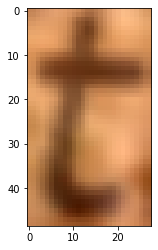

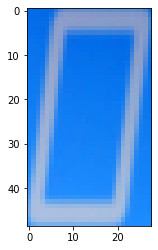

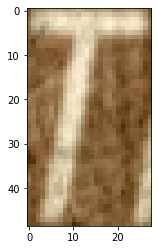

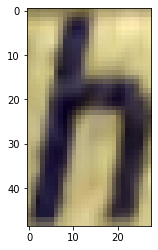

In [9]:
for i in range(0, 12000, 3000):
    plt.figure()
    plt.imshow(x_train[i], cmap="gray")

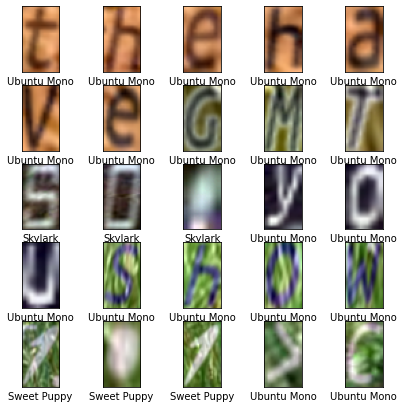

In [10]:
def draw_train_samples():
    plt.figure(figsize=(7, 7))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_train[i], cmap="gray")
        plt.xlabel(y_train[i])
    plt.show()

draw_train_samples()

### Assertions

In [11]:

for x in x_train:
    assert x.shape[0] == avg_cropped_char_height
    assert x.shape[1] == avg_cropped_char_width
    assert x.shape[2] == 3
    

for y in y_train:
    assert type(y) == str
    assert y != None and y != ""
    

### Bad image

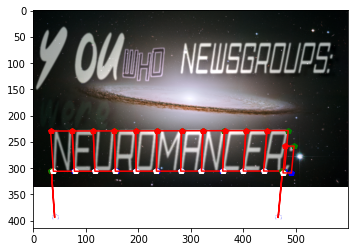

In [12]:
i = 287
#i = 4
res = extract_data(IM_NAMES[i])

plt.figure()
plt.imshow(res["img"])


for char in res["words"][1]["chars"]:
    draw_bb(char["bb"])

### Example extract_data

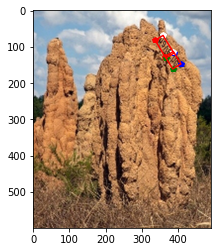

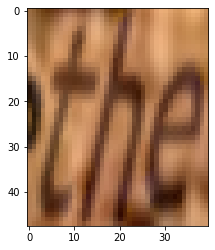

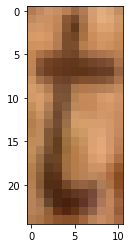

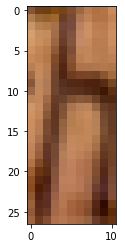

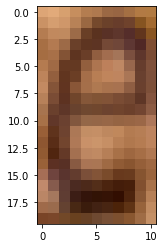

In [13]:
img_name = IM_NAMES[0]
img = db['data'][img_name][:]
plt.figure()
plt.imshow(img)
wordBB = db['data'][img_name].attrs['wordBB']

draw_bb(wordBB)

res = extract_data(img_name)

plt.figure()
plt.imshow(res["words"][0]["crop"])

word = res["words"][0]

for char in word["chars"]:
    plt.figure()
    plt.imshow(char["crop"])


(49, 28, 3) <class 'list'>
(49, 28, 3) <class 'list'>
(49, 28, 3) <class 'list'>
(49, 28, 3) <class 'list'>
(49, 28, 3) <class 'list'>
(49, 28, 3) <class 'list'>
(49, 28, 3) <class 'list'>
(49, 28, 3) <class 'list'>
(49, 28, 3) <class 'list'>
(49, 28, 3) <class 'list'>


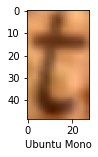

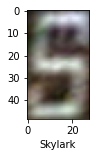

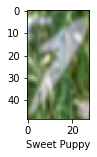

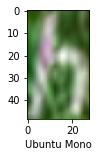

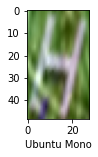

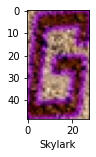

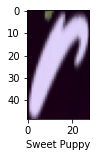

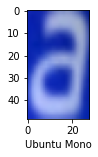

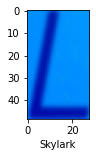

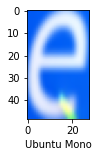

In [14]:
for i in range(0, 100, 10):
    plot_sample(x_train, y_train, i)
    print(x_train[i].shape, type(x_train))

## Create model

In [15]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(avg_cropped_char_height,avg_cropped_char_width,3)),
        tf.keras.layers.Dense(3000, activation='relu'),
        tf.keras.layers.Dense(1000, activation='relu'),
        tf.keras.layers.Dense(3, activation='sigmoid') 
])

model.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4116)              0         
_________________________________________________________________
dense (Dense)                (None, 3000)              12351000  
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              3001000   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3003      
Total params: 15,355,003
Trainable params: 15,355,003
Non-trainable params: 0
_________________________________________________________________


## Convert y_train strings to float

In [16]:
X = np.asarray(x_train)
#Y = np.asarray(y_train)

new_y = []
for y in y_train:
    if y == "Ubuntu Mono":
        new_y.append(0)
    elif y == "Skylark":
        new_y.append(1)
    elif y == "Sweet Puppy":
        new_y.append(2)
    else:
        raise "Error font"
Y = np.array(new_y)

print("x_train: ", type(x_train), len(x_train), x_train[0].shape)
print("X: ", type(X), X.shape, type(X[0]), X[0].dtype)
print("Y: ", type(Y), Y.shape, type(Y[0]))

x_train:  <class 'list'> 12236 (49, 28, 3)
X:  <class 'numpy.ndarray'> (12236, 49, 28, 3) <class 'numpy.ndarray'> float64
Y:  <class 'numpy.ndarray'> (12236,) <class 'numpy.int32'>


## Train

In [17]:
%%time
history = model.fit(X, Y, epochs=40, validation_split=0.2) # Split 20% is validation, 80% training

Epoch 1/40
306/306 [==============================] - 17s 55ms/step - loss: 0.7736 - accuracy: 0.6637 - val_loss: 0.5321 - val_accuracy: 0.8129
Epoch 2/40
306/306 [==============================] - 16s 52ms/step - loss: 0.4460 - accuracy: 0.8306 - val_loss: 0.4054 - val_accuracy: 0.8313
Epoch 3/40
306/306 [==============================] - 16s 52ms/step - loss: 0.3326 - accuracy: 0.8803 - val_loss: 0.3208 - val_accuracy: 0.8681
Epoch 4/40
306/306 [==============================] - 17s 57ms/step - loss: 0.2801 - accuracy: 0.8935 - val_loss: 0.3298 - val_accuracy: 0.8746
Epoch 5/40
306/306 [==============================] - 17s 56ms/step - loss: 0.2429 - accuracy: 0.9101 - val_loss: 0.2579 - val_accuracy: 0.9032
Epoch 6/40
306/306 [==============================] - 16s 52ms/step - loss: 0.2227 - accuracy: 0.9164 - val_loss: 0.2465 - val_accuracy: 0.9048
Epoch 7/40
306/306 [==============================] - 16s 51ms/step - loss: 0.2003 - accuracy: 0.9265 - val_loss: 0.2196 - val_accuracy:

## Draw result for training

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


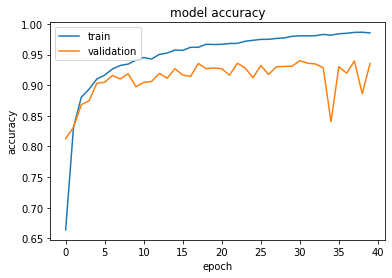

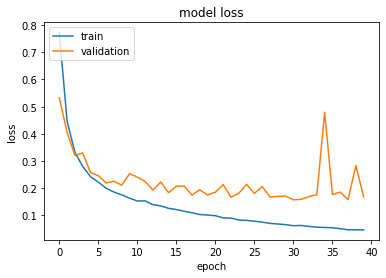

In [18]:
print(history.history.keys())

# summarize history for accuracy
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Predict

In [20]:
model.predict_classes